<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/KerasRegAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import keras
import pandas as pd
import numpy as np

In [2]:
downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

Streaming output truncated to the last 5000 lines.
  inflating: train_set/train_set/train_55.jpg  
  inflating: train_set/train_set/train_550.jpg  
  inflating: train_set/train_set/train_5500.jpg  
  inflating: train_set/train_set/train_5501.jpg  
  inflating: train_set/train_set/train_5502.jpg  
  inflating: train_set/train_set/train_5503.jpg  
  inflating: train_set/train_set/train_5504.jpg  
  inflating: train_set/train_set/train_5505.jpg  
  inflating: train_set/train_set/train_5506.jpg  
  inflating: train_set/train_set/train_5507.jpg  
  inflating: train_set/train_set/train_5508.jpg  
  inflating: train_set/train_set/train_5509.jpg  
  inflating: train_set/train_set/train_551.jpg  
  inflating: train_set/train_set/train_5510.jpg  
  inflating: train_set/train_set/train_5511.jpg  
  inflating: train_set/train_set/train_5512.jpg  
  inflating: train_set/train_set/train_5513.jpg  
  inflating: train_set/train_set/train_5514.jpg  
  inflating: train_set/train_set/train_5515.jpg  
  i

In [10]:
traindf = pd.read_csv('data/train_labels.csv',dtype=str)
testdf = pd.read_csv('data/sample.csv',dtype=str)

# Data augumentation
# image_gen_train = ImageDataGenerator(
#                     rescale=1./255,
#                     rotation_range=45,
#                     width_shift_range=.15,
#                     height_shift_range=.15,
#                     horizontal_flip=True,
#                     zoom_range=0.5
#                     )
# train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
#                                                      directory=train_dir,
#                                                      shuffle=True,
#                                                      target_size=target_size,
#                                                      class_mode='binary')
# image_gen_val = ImageDataGenerator(rescale=1./255)
# val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
#                                                  directory=test_dir,
#                                                  target_size=target_size,
#                                                  class_mode='binary')
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5,
    validation_split=0.20)

batch_size = 32
image_size = (224,224)

train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="data/train_set/train_set/",
x_col="img_name",
y_col="label",
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size)

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="data/train_set/train_set/",
x_col="img_name",
y_col="label",
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="data/test_set/test_set/",
x_col="img_name",
y_col="label",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=image_size)

Found 24490 validated image filenames belonging to 80 classes.
Found 6122 validated image filenames belonging to 80 classes.
Found 7653 validated image filenames.


In [11]:


# with drop out


model = Sequential()
model.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(224,224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(8, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(300, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(Dropout(0.2))
model.add(layers.Dense(100, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(layers.Dense(80, activation = 'softmax'))
model.summary()

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=["accuracy"])


#from tensorflow.keras import EarlyStopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.01,mode = 'min',
  patience=5,verbose = 0, restore_best_weights = True)

epochs = 50
# history = model.fit_generator(
#     train_data_gen,
#     steps_per_epoch=8005// batch_size,
#     epochs=epochs,callbacks = [earlystop_callback],
#     validation_data=val_data_gen,
#     validation_steps=2023// batch_size
# )

history = model.fit(
    train_generator, 
    epochs=epochs, 
    callbacks = [earlystop_callback],
    validation_data=valid_generator, verbose=1
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 218, 218, 32)      4736      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 105, 105, 16)      12816     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 52, 52, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 51, 51, 8)         520       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)             

In [12]:
model.evaluate(valid_generator)

192/192 [==============================] - 78s 409ms/step - loss: 3.4409 - accuracy: 0.1531


[3.440932273864746, 0.15305455029010773]

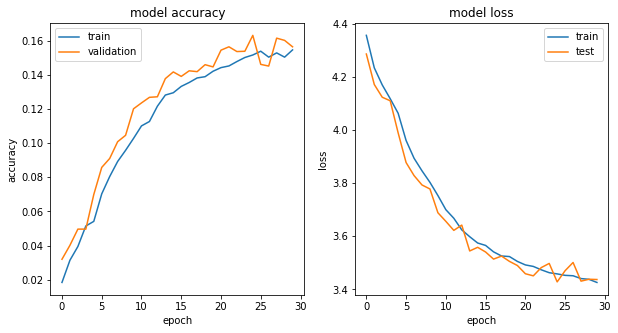

In [13]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 
plot_acc_loss(history)

https://heartbeat.fritz.ai/regularization-techniques-for-image-processing-using-tensorflow-56c5b365bc17